In [140]:
import os
from datetime import date, datetime, timedelta
from typing import Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from dotenv import load_dotenv
from faker import Faker
import random

from plaid.api import plaid_api
from plaid.model.transactions_get_request import TransactionsGetRequest
import plaid

from data_fetch import TransactionProcessor, PlaidClient

EXCLUDED_COLUMNS = ['transaction_id', 'authorized_date', 'date']
MODEL_PATH = 'vae_model_2.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [141]:
def load_data(file_path):
    try:
        df = pd.read_csv(file_path)
        if df.shape[0] > 0:
            print("Data loaded successfully!")
            return df
        else:
            raise ValueError("No data to load!")
    except FileNotFoundError:
        print("No data to load or file not found!")
        client = PlaidClient()
        data = TransactionProcessor.combine_data(client)
        data.to_csv(file_path, index=False)
        print("Data fetched and saved to transactions.csv")
        return data

In [142]:
df = load_data('/Users/ahtiholli/TransactionOutliers/files/transactions.csv')

Data loaded successfully!


In [143]:
def encode_labels(raw_data):
    non_numeric_cols = raw_data.select_dtypes(include=['object', 'bool']).columns
    label_encoders = {}
    for column in non_numeric_cols:
        le = LabelEncoder()
        raw_data[column] = le.fit_transform(raw_data[column].astype(str))
        label_encoders[column] = le
    
    if not np.issubdtype(raw_data.values.dtype, np.number):
        raise ValueError("Data contains non-numeric values after encoding")
    
    return raw_data

def preprocess_data(df):
    raw_data = df.copy()
    encoded_data = encode_labels(raw_data)
    data = encoded_data.drop(columns=EXCLUDED_COLUMNS)
    data = data.dropna()
    data_tensor = torch.tensor(data.values, dtype=torch.float32)
    
    if torch.isnan(data_tensor).any() or torch.isinf(data_tensor).any():
        raise ValueError("Input data contains NaN or Inf values!")
    
    return data_tensor


In [144]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=np.random.randint(0, 10000))

train_tensor = preprocess_data(train_df)
test_tensor = preprocess_data(test_df)
    
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=32, shuffle=False)


In [145]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 2 * latent_dim),
        )
        self.softplus = nn.Softplus()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def encode(self, x, eps=1e-8):
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(log_var) + eps
        scale_tril = torch.diag_embed(scale)
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)

    def reparameterize(self, dist):
        return dist.rsample()

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        dist = self.encode(x)
        z = self.reparameterize(dist)
        if z.isnan().any():
            print("Latent space contains NaNs!")
        reconstructed = self.decode(z)
        return reconstructed, z, dist

In [146]:
def vae_loss(reconstructed, original, z, dist):
    recon_loss = nn.MSELoss()(reconstructed, original)
    std_normal = torch.distributions.MultivariateNormal(
        torch.zeros_like(z, device=z.device),
        scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
    )
    kl_div = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
    return recon_loss + kl_div

In [147]:
def load_or_train_model(train_loader):
    model = VAE(input_dim=12, hidden_dim=36, latent_dim=2)
    if os.path.exists(MODEL_PATH):
        model.load_state_dict(torch.load(MODEL_PATH))
        print("Model loaded from disk.")
    else:
        train(model, train_loader, epochs=100)
        torch.save(model.state_dict(), MODEL_PATH)
        print("Model trained and saved to disk.")
    return model

def train(model, data_loader, epochs=1, learning_rate=1e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in data_loader:
            x = batch[0].to(device)
            reconstructed_x, z, dist = model(x)
            loss = vae_loss(reconstructed_x, x, z, dist)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(data_loader):.4f}")

In [148]:
model = load_or_train_model(train_loader)
original, reconstructed, errors, outlier_df = evaluate(model, test_loader, test_df)
test_df['reconstruction_error'] = errors

Model loaded from disk.


In [149]:
outliers = test_df[test_df['outlier'] == True]
print(outliers)

outlier_df = test_df.drop(columns=['outlier', 'reconstruction_error'])
outlier_tensor = preprocess_data(outlier_df)

# Get the indices of the outliers in the original DataFrame
outlier_indices = outliers.index
print(outlier_indices)
# Map the outlier indices to the outlier tensor
mapped_indices = [i for i, idx in enumerate(outlier_df.index) if idx in outlier_indices]
print(mapped_indices)

# Example of finding a specific value in the tensor
index = (outlier_tensor[:, 1] == -500).nonzero(as_tuple=True)[0]
print(index)

                               account_id  amount authorized_date  \
26  NvxzNa9NvDCnXvGBr9NjhlPlqqjQWxuy6pnQ6 -500.00      2024-07-21   
0   Pva3WNwWvDCezB1EG6Nks37399kEMwco65QAl   25.00      2024-10-20   
17  NvxzNa9NvDCnXvGBr9NjhlPlqqjQWxuy6pnQ6    5.40      2024-08-21   
1   NvxzNa9NvDCnXvGBr9NjhlPlqqjQWxuy6pnQ6    5.40      2024-10-20   
22  Pva3WNwWvDCezB1EG6Nks37399kEMwco65QAl   -4.22      2024-08-17   
25  NvxzNa9NvDCnXvGBr9NjhlPlqqjQWxuy6pnQ6    5.40      2024-07-22   

    category_id        date iso_currency_code    merchant_name  \
26     22001000  2024-07-21               USD  United Airlines   
0      16001000  2024-10-21               USD              NaN   
17     22016000  2024-08-22               USD             Uber   
1      22016000  2024-10-21               USD             Uber   
22     21009000  2024-08-17               USD              NaN   
25     22016000  2024-07-23               USD             Uber   

                            name payment_channel  pen

In [150]:
def plot_anomalies(original_df):
    outlier_df = original_df[original_df['outlier']]
    plt.figure(figsize=(14, 6))
    plt.scatter(outlier_df['date'], outlier_df['amount'], c='red', alpha=0.5)
    plt.title('Anomaly Detection Visualization')
    plt.xlabel('Date')
    plt.ylabel('Amount')
    plt.show()

def plot_reconstruction(reconstruction_errors):
    plt.figure(figsize=(10, 6))
    plt.hist(reconstruction_errors, bins=50, alpha=0.7)
    plt.title('Distribution of Reconstruction Errors')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.show()
    
def plot_latent_space(model, original_df, outlier_indices):
    latent_representations = model.encoder(original_df).detach().cpu().numpy()

    # Example with PCA
    pca = PCA(n_components=2)
    reduced_latent_pca = pca.fit_transform(latent_representations)

    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_latent_pca[:, 0], reduced_latent_pca[:, 1], alpha=0.5, label='Normal')

    # Highlight outliers in a different color

    plt.scatter(reduced_latent_pca[outlier_indices, 0], reduced_latent_pca[outlier_indices, 1], c='red', alpha=0.5, label='Outlier')

    plt.title('PCA of Latent Space with Outliers Highlighted')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.show()

    # Example with t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    reduced_latent_tsne = tsne.fit_transform(latent_representations)

    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_latent_tsne[:, 0], reduced_latent_tsne[:, 1], alpha=0.5, label='Normal')
    plt.scatter(reduced_latent_tsne[outlier_indices, 0], reduced_latent_tsne[outlier_indices, 1], c='red', alpha=0.5, label='Outlier')

    plt.title('t-SNE of Latent Space with Outliers Highlighted')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()


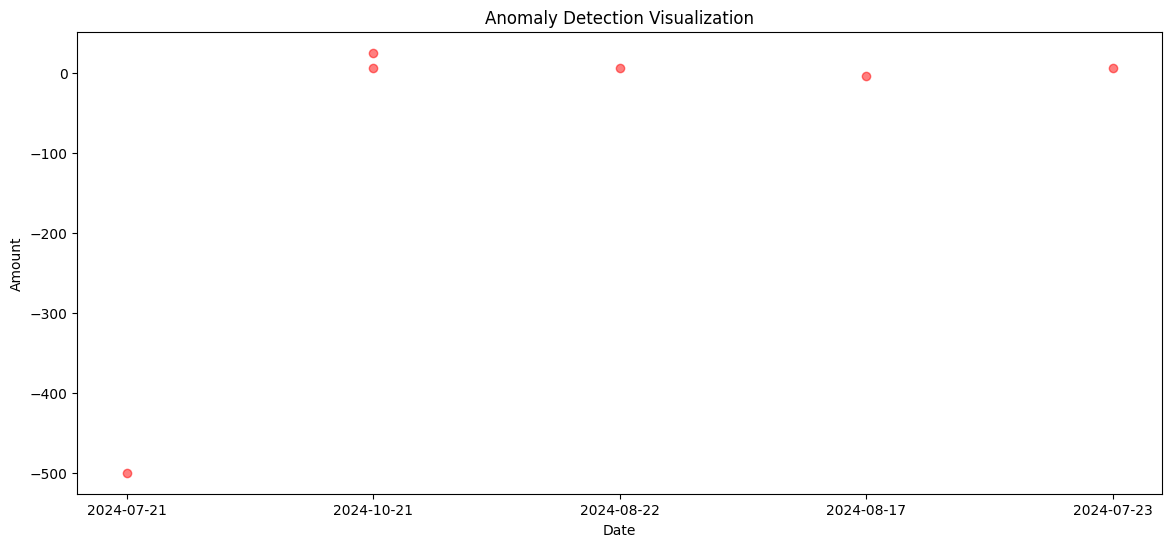

In [151]:
plot_anomalies(test_df)

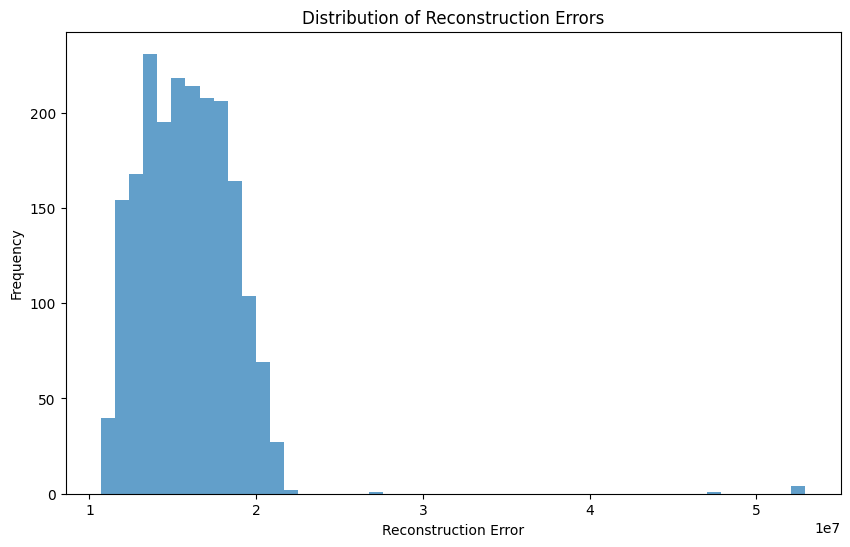

In [152]:
plot_reconstruction(errors)

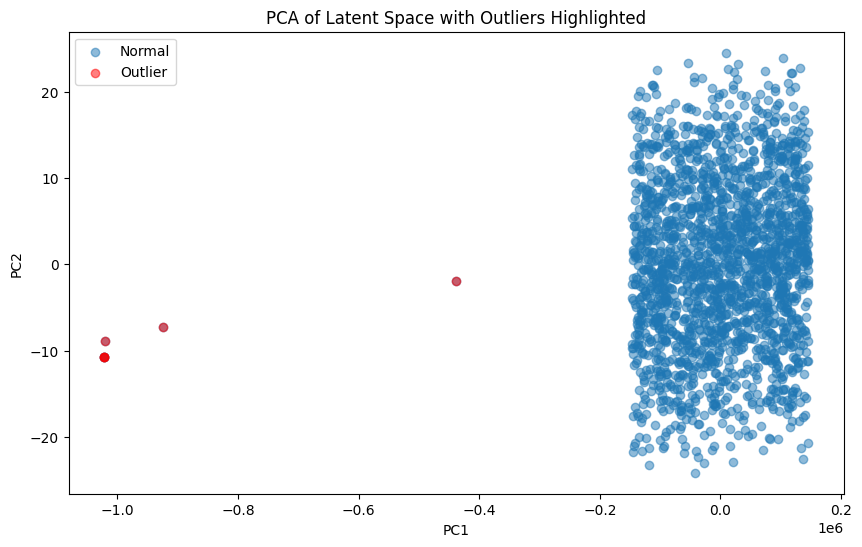

/Users/ahtiholli/opt/anaconda3/envs/trader/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


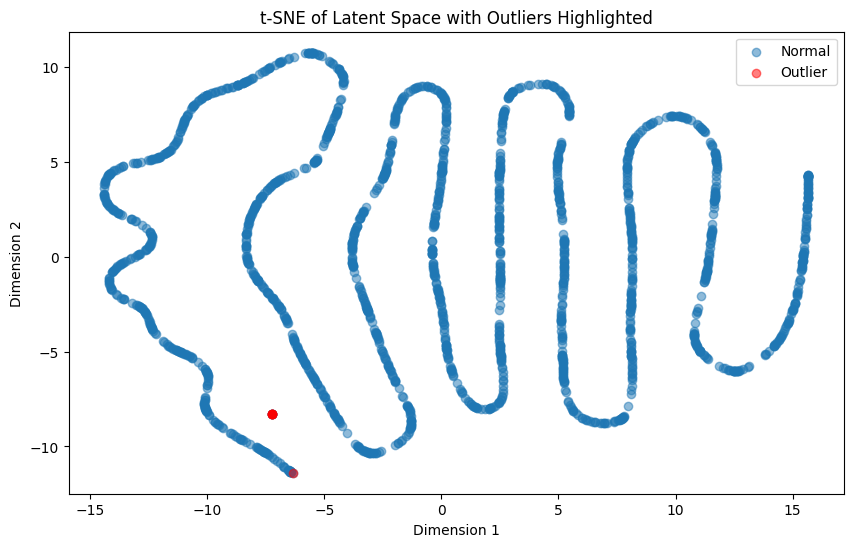

In [153]:
plot_latent_space(model, outlier_tensor, mapped_indices)